In [10]:
import glob
import os
import pandas as pd
import csv
from types import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Function definitions

In [11]:
from skbio.diversity import beta_diversity

beta_diversity("braycurtis", od.X_profiles)

NameError: name 'od' is not defined

In [12]:
def read_cog_profiles(path_to_profiles_msk, profile_headers_path, min_cog_cutoff_pct=0.4, ids_to_filter=[]):
    """
    Each cog profile is a tab-separated file with 2 columns: cog id and count.
    """
    cog_list=pd.read_csv(profile_headers_path, delimiter='\t').loc[:,'COG ID'].tolist()
    min_cog_cutoff =  len(cog_list) * min_cog_cutoff_pct
  
    selected_genomes = pd.DataFrame(columns=["taxon_oid"]+cog_list)
    columns_selected_genomes = selected_genomes.columns.tolist()
    file_lst=glob.glob(path_to_profiles_msk)
    for file in file_lst:
        filename = os.path.basename(file)
        oid = os.path.splitext(filename)[0]
        oid = oid.split("_")[0]
        
        if oid in ids_to_filter:
            print(f"\tSkipping: {file}...")
            continue
        
        current_profile = pd.read_csv(file, delimiter='\t').fillna(value=0) 
        if len(current_profile) < min_cog_cutoff:
            print(f"\tLess than {min_cog_cutoff_pct*100}% COGs present, skipping: {file}...")
            continue
        
        current_profile = current_profile.loc[:, ~current_profile.columns.str.match('Unnamed')]
        old2new_names = {old:new for old,new in zip(current_profile.columns, ["COG ID", "COG Name", "Gene Count"])}
        current_profile.rename(columns=old2new_names, inplace=True)
        current_profile.astype({'Gene Count': 'float64'})
        
        dct_current_profile = current_profile.set_index('COG ID')['Gene Count'].to_dict()
        
        assert len(dct_current_profile) == len(current_profile.index), "Error during importing file: %s. Sizes do not match." % file
        
        #failed when importing relative counts
        #assert sum(dct_current_profile.values()) == current_profile['Gene Count'].sum(), "Error during importing file: %s. Gene counts do not match." % file
        
        dct_current_profile['taxon_oid'] = oid
        temp_profile = pd.DataFrame([dct_current_profile])
        selected_genomes = pd.concat([selected_genomes, temp_profile], ignore_index=True).fillna(value=0)
        print(oid)
        
    return selected_genomes

In [13]:
def convert_to_relative_counts(df):
    """
    Converting dataframe with a first column of taxon_oid to relative counts.
    """
    relative_df = df.iloc[:,1:].apply(lambda x: x/x.sum()*100,  axis=1)
    relative_df.insert(0, "taxon_oid", df['taxon_oid'])
    return relative_df

In [14]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import correlation

class MetaSimilarity:
    def __init__(self, profiles_df, target_id, metadata_path="", metrics=[], by_taxon_oid=True):
        self.profiles_df = profiles_df
        self.meta_similarity = pd.DataFrame(self.profiles_df['taxon_oid'].copy())
        self.target_id = target_id
        self.by_taxon_oid = by_taxon_oid
        self.target = self.profiles_df.loc[profiles_df['taxon_oid']==self.target_id].iloc[0, 1:].tolist()
        
        if not metrics:
            self.distance_metrics = ['cosine', 'braycurtis', 'correlation', 'jaccard']
        else:
            self.distance_metrics = metrics
        self.metric_to_function_dct = {'cosine': self.cosine_to_target,
                                          'braycurtis': self.braycurtis_to_target,
                                          'correlation': self.correlation_to_target,
                                          'jaccard': self.jaccard_to_target}
        if metadata_path:
            self.import_metadata(metadata_path)
        else:
            self.metadata_df = None
    
    def import_metadata(self, metadata_pt):
        self.metadata_df = pd.read_csv(metadata_pt, sep='\t', index_col="taxon_oid")
        self.metadata_df = self.metadata_df.loc[:, ~self.metadata_df.columns.str.match('Unnamed')]
        self.metadata_df.index = self.metadata_df.index.astype('str', copy=False)
        
    def get_meta_similarity_w_metadata(self):
        if self.by_taxon_oid:
            return self.meta_similarity.merge(self.metadata_df, 
                                              how='left', left_on='taxon_oid', right_index=True)
        else:
            return self.meta_similarity.merge(self.metadata_df.reset_index(drop=True), 
                                       how='left', left_on='taxon_oid', right_on="GOLD Analysis Project ID")
    
    def export_meta_similarity(self, out_file_path, w_metadata=False):
        if w_metadata:
            df = self.get_meta_similarity_w_metadata()
        else:
            df = self.meta_similarity
        
        df.to_csv(out_file_path, sep='\t', index=False)
        
    
    def calculate_target_distances(self):
        for metric in self.distance_metrics:
            self.meta_similarity[metric+"_to_target"] = self.profiles_df.apply(self.metric_to_function_dct[metric],
                                                                              args=(self.target, metric), axis=1)
    def jaccard_to_target(self, x, target, met):
        return float(1-pairwise_distances(np.array([x.iloc[1:].tolist()], dtype='bool'), np.array([target], dtype='bool'), metric=met))
    
    def cosine_to_target(self, x, target, met):
        return float(1-pairwise_distances([x.iloc[1:].tolist()], [target], metric=met))
    
    def correlation_to_target(self, x, target, met):
        return float(1-pairwise_distances([x.iloc[1:].tolist()], [target], metric=met))
    
    def braycurtis_to_target(self, x, target, met):
        return float(1-pairwise_distances([x.iloc[1:].tolist()], [target], metric=met))
    

In [15]:
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, discriminant_analysis
from math import atan2, pi
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import numpy as np


class Ordination:
    def __init__(self, profiles_df, target_id=None, metadata_path="", 
                 by_taxon_oid=True, profile_metadata_path=""):
        self.profiles_df = profiles_df
        
        self.target_id = target_id
        self.by_taxon_oid = by_taxon_oid
        
        if self.target_id:
            #self.target = self.profiles_df.loc[profiles_df['taxon_oid']==self.target_id].iloc[0, 1:].tolist()
            self.target_idx_lst = self.profiles_df.index[self.profiles_df['taxon_oid'].isin(self.target_id)].tolist()
        else:
            self.target_idx_lst = []
        if metadata_path:
            self.import_metadata(metadata_path)
        else:
            self.metadata_df = None
            
        if profile_metadata_path:
            self.profile_metadata = self.read_profile_metadata(profile_metadata_path)
        else:
            self.profile_metadata = None
            
        self.X_profiles = self.profiles_df.set_index('taxon_oid', drop=True).values
        self.X_idx = self.profiles_df.index.values
        self.x_labels = self.profiles_df.iloc[:, 0].values
        
        self.bray_dist_mtrx = pairwise_distances(self.X_profiles, metric='braycurtis', n_jobs=-1)
        self.cosine_dist_mtrx = pairwise_distances(self.X_profiles, metric='cosine', n_jobs=-1)
        self.jaccard_dist_mtrx = pairwise_distances(self.X_profiles.astype(np.bool), metric='jaccard', n_jobs=-1)       
        
        self.pca_dct = self.calculate_pca()
        self.kpca_dct = self.calculate_kpca()
        self.pcoa_dct = self.calculate_pcoa()
    
    def read_profile_metadata(self, path):
        full_md_list = pd.read_csv(path, delimiter='\t')
        full_md_list = full_md_list.loc[:, ~full_md_list.columns.str.match('Unnamed')]
        
        return full_md_list
        
        
    def add_metadata(self, data):
        if self.by_taxon_oid:
            return data.merge(self.metadata_df, 
                                              how='left', left_on='taxon_oid', right_index=True)
        else:
            return data.merge(self.metadata_df.reset_index(drop=True), 
                                       how='left', left_on='taxon_oid', right_on="GOLD Analysis Project ID")
        
    def calculate_kpca(self, data=None, n_comp=2, kernel='linear'):
        if data is None:
            data = self.X_profiles
            #print(data)
        
        model = decomposition.KernelPCA(n_components=n_comp, kernel=kernel)
        #print(type(data))
        results = model.fit_transform(data)
        sample_pos = pd.DataFrame(results)
        sample_pos.rename(columns={0: 'PC1', 1: 'PC2', 2:'PC3'}, inplace=True)
        sample_pos['taxon_oid']  = self.profiles_df.taxon_oid.copy()
        
        
        
        sample_pos['angle'] = sample_pos.apply(lambda x: atan2(x[1], x[0])* (180 / pi), axis=1)
        if self.metadata_df is not None:
            sample_pos = self.add_metadata(sample_pos)
        
        
    
#         if self.profile_metadata is not None:
#             components[['ID', "Name"]] = self.profile_metadata.iloc[:]
        
        pcr_dct = {}       
        pcr_dct['model'] = model
        pcr_dct['results'] = results
        
        pcr_dct['sample_pos'] = sample_pos

        
        return pcr_dct
    
    def calculate_pcoa(self, data=None, n_comp=3):
        if data is None:
            data = self.bray_dist_mtrx
            #print(data)
        
        pcoa_output = pcoa(data, number_of_dimensions=0)
        #print(type(data))
        #results = model.fit_transform(data)
        results = pcoa_output.samples.iloc[:,0:n_comp].values
        sample_pos = pcoa_output.samples.iloc[:,0:n_comp].copy()
        sample_pos['taxon_oid']  = self.profiles_df.taxon_oid.values

        #sample_pos.rename(columns={0: 'PC1', 1: 'PC2'}, inplace=True)
        
        
        sample_pos['angle'] = sample_pos.apply(lambda x: atan2(x[1], x[0])* (180 / pi), axis=1)
        if self.metadata_df is not None:
            sample_pos = self.add_metadata(sample_pos)
        expl_var = pcoa_output.proportion_explained.iloc[:n_comp]
        
# #         components = pd.DataFrame(np.transpose(model.components_[0:2, :]))
# #         components = components.rename(columns={0: 'PC1', 1: 'PC2'})
#         components['angle'] = components.apply(lambda x: atan2(x[1], x[0])* (180 / pi), axis=1)
#         components['abs'] = np.sqrt(components.iloc[:, 0]**2 + components.iloc[:, 1]**2)
        
#         if self.profile_metadata is not None:
#             components[['ID', "Name"]] = self.profile_metadata.iloc[:]
        
        pcr_dct = {}       
        #pcr_dct['output'] = model
        pcr_dct['results'] = results
        pcr_dct['expl_var'] = expl_var
        pcr_dct['sample_pos'] = sample_pos
        pcr_dct['pcoa_output'] = pcoa_output
        #pcr_dct['components'] = components
        
        return pcr_dct
    
    def calculate_pca(self, data=None, n_comp=2):
        if data is None:
            data = self.X_profiles
            #print(data)
        
        model = decomposition.PCA(n_components=n_comp)
        #print(type(data))
        results = model.fit_transform(data)
        sample_pos = pd.DataFrame(results)
        sample_pos.rename(columns={0: 'PC1', 1: 'PC2', 2:'PC3'}, inplace=True)
        sample_pos['taxon_oid']  = self.profiles_df.taxon_oid.copy()
        
        
        
        sample_pos['angle'] = sample_pos.apply(lambda x: atan2(x[1], x[0])* (180 / pi), axis=1)
        if self.metadata_df is not None:
            sample_pos = self.add_metadata(sample_pos)
        expl_var = model.explained_variance_ratio_
        
        components = pd.DataFrame(np.transpose(model.components_[0:2, :]))
        components = components.rename(columns={0: 'PC1', 1: 'PC2'})
        components['angle'] = components.apply(lambda x: atan2(x[1], x[0])* (180 / pi), axis=1)
        components['abs'] = np.sqrt(components.iloc[:, 0]**2 + components.iloc[:, 1]**2)
        
        if self.profile_metadata is not None:
            components[['ID', "Name"]] = self.profile_metadata.iloc[:]
        
        pcr_dct = {}       
        pcr_dct['model'] = model
        pcr_dct['results'] = results
        pcr_dct['expl_var'] = expl_var
        pcr_dct['sample_pos'] = sample_pos
        pcr_dct['components'] = components
        
        return pcr_dct
    
    def ordination_plot(self, ordination_dct, n_axes=2):
        if n_axes == 2:
            self.ordination_plot_2d(ordination_dct)
        elif n_axes == 3:
            self.ordination_plot_3d(ordination_dct)
            
    def ordination_plot_3d(self, ordination_dct):
        pos = ordination_dct['results']
        fig = plt.figure(figsize=(8.4, 6.8))
        ax = fig.add_subplot(projection='3d')
        #ax.scatter(pos[:,0], pos[:,1], pos[:,2], facecolor=(0,0,0,0), edgecolor='b')
        #ax.set_facecolor('none')
        for idx in range(np.shape(ordination_dct['results'])[0]):
            if idx in self.target_idx_lst:
                ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], c='r', edgecolor='r') 
            else:
                ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], facecolor=(0,0,0,0), edgecolor='b') 
        plt.show()
    
    def ordination_plot_2d(self, ordination_dct):
        pos = ordination_dct['results']
        #facecolors='none', edgecolors='r'
        
        #plt.scatter(pos[:,0], pos[:,1], facecolors='none', edgecolors='b')
        for idx in range(np.shape(ordination_dct['results'])[0]):
            if idx in self.target_idx_lst:
                plt.scatter(pos[idx][0], pos[idx][1], c='r', edgecolor='r')
            else:
                plt.scatter(pos[idx][0], pos[idx][1], facecolor='none', edgecolor='b')
        plt.show()
        
    def import_metadata(self, metadata_pt):
        self.metadata_df = pd.read_csv(metadata_pt, sep='\t', index_col="taxon_oid")
        self.metadata_df = self.metadata_df.loc[:, ~self.metadata_df.columns.str.match('Unnamed')]
        self.metadata_df.index = self.metadata_df.index.astype('str', copy=False)

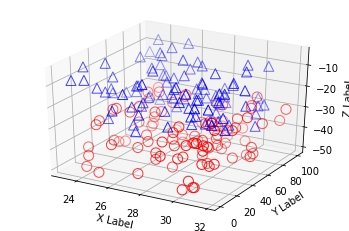

In [16]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zl, zh)
    ax.scatter(xs, ys, zs, facecolor=(0,0,0,0), s=100, marker=m, edgecolor=c)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

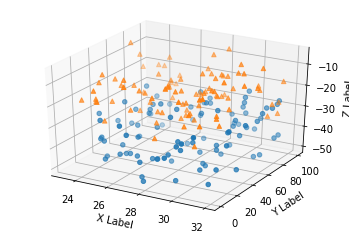

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Running the analysis

In [18]:
#ga
profiles = read_cog_profiles("processed_profiles_combined/*", 
                             'coglist123340_25-mar-2018.tsv', 
                             ids_to_filter=[], min_cog_cutoff_pct=0.4)

	Less than 40.0% COGs present, skipping: processed_profiles_combined/Ga0003071_filtered.tsv...
Ga0010857
Ga0010913
Ga0010914
	Less than 40.0% COGs present, skipping: processed_profiles_combined/Ga0010923_filtered.tsv...
Ga0011089
Ga0011115
Ga0011178
Ga0011208
	Less than 40.0% COGs present, skipping: processed_profiles_combined/Ga0011247_filtered.tsv...
Ga0011249
Ga0011301
	Less than 40.0% COGs present, skipping: processed_profiles_combined/Ga0011316_filtered.tsv...
Ga0011318
Ga0011319
Ga0011321
Ga0011577
	Less than 40.0% COGs present, skipping: processed_profiles_combined/Ga0011597_filtered.tsv...
Ga0012390
Ga0012981
Ga0022193
Ga0022196
Ga0023037
	Less than 40.0% COGs present, skipping: processed_profiles_combined/Ga0052169_filtered.tsv...
Ga0052266
Ga0052267
Ga0057740
Ga0057741
Ga0059327
Ga0064592
Ga0070393
Ga0070394
Ga0070396
Ga0073583
Ga0074127
Ga0075519
Ga0075526
Ga0075530
Ga0102924
Ga0114984
Ga0120086
Ga0120090
Ga0120109
Ga0136806
Ga0136821
Ga0156901
Ga0159060
Ga0167657
Ga0167665


In [19]:
profiles = convert_to_relative_counts(profiles)

In [449]:
# #taxon_oid
# profiles = read_cog_profiles("processed_cog_summaries_taxon_oid/*tsv", 
#                              'coglist123340_25-mar-2018.tsv', 
#                              ids_to_filter=['3300038493'],
#                             min_cog_cutoff_pct=0.7)

	Less than 70.0% COGs present, skipping: processed_cog_summaries_taxon_oid/3300034404_filtered_cog.tsv...
	Skipping: processed_cog_summaries_taxon_oid/3300038493_filtered_cog.tsv...
3300045129
3300045855


In [20]:
#ms = MetaSimilarity(profiles, "3300045129", metrics=[], metadata_path="36_mg_basic_metadata.tsv")
ms = MetaSimilarity(profiles, "Ga0495008", metrics=[], metadata_path="metadata/metadata_combined.tsv", by_taxon_oid=False)

In [21]:
ms.calculate_target_distances()

In [22]:
ms.meta_similarity

,taxon_oid,cosine_to_target,braycurtis_to_target,correlation_to_target,jaccard_to_target
0,Ga0010857,0.679105,0.623045,0.600689,0.653893
1,Ga0010913,0.717208,0.632672,0.651247,0.547724
2,Ga0010914,0.699820,0.627096,0.630287,0.546768
3,Ga0011089,0.798564,0.706669,0.755021,0.782521
4,Ga0011115,0.693153,0.634228,0.629689,0.666581
...,...,...,...,...,...
116,Ga0484791,0.801498,0.693745,0.756091,0.757035
117,Ga0484792,0.741350,0.656354,0.680349,0.748692
118,Ga0486823,0.838012,0.728740,0.809542,0.800351
119,Ga0491191,0.797659,0.699991,0.755950,0.819684


In [23]:
ms.get_meta_similarity_w_metadata()

,taxon_oid,cosine_to_target,braycurtis_to_target,correlation_to_target,jaccard_to_target,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,...,ITS SP ID,ITS Proposal ID,JGI Data Utilization Status,GPTS Proposal ID,Number of Filtered Reads * assembled,Number of Mapped Reads * assembled,% Assembled Reads * assembled,Total Filtered Bases * assembled,Total Mapped Bases * assembled,Average Coverage of Assembled Sequences * assembled
0,Ga0010857,0.679105,0.623045,0.600689,0.653893,*Microbiome,Permanent Draft,Groundwater microbial communities from well in...,Groundwater microbial communities from well in...,"University of California, Berkeley",...,0,NaN,NaN,NaN,0,0,0.00,0,0,0.00
1,Ga0010913,0.717208,0.632672,0.651247,0.547724,*Microbiome,Permanent Draft,Acid mine drainage microbial communities from ...,Acid Mine Drainage metagenome from Yunfu pyrit...,Sun Yat-Sen University,...,0,NaN,NaN,NaN,0,0,0.00,0,0,0.00
2,Ga0010914,0.699820,0.627096,0.630287,0.546768,*Microbiome,Permanent Draft,Acid mine drainage microbial communities from ...,Acid Mine Drainage metagenome from Dabaoshan,Sun Yat-Sen University,...,0,NaN,NaN,NaN,0,0,0.00,0,0,0.00
3,Ga0011089,0.798564,0.706669,0.755021,0.782521,*Microbiome,Finished,Speleothem and rock wall surfaces microbial co...,Echo Passage metagenome,Arizona Genomics Institute,...,0,NaN,NaN,NaN,0,0,0.00,0,0,0.00
4,Ga0011115,0.693153,0.634228,0.629689,0.666581,*Microbiome,Permanent Draft,Freshwater lake biofilm microbial communities ...,Anoxic freshwater biofilm from cave wall in La...,Pennsylvania State University,...,0,NaN,NaN,NaN,0,0,0.00,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Ga0484791,0.801498,0.693745,0.756091,0.757035,*Microbiome,Permanent Draft,Methane metabolizing microbial communities fro...,Shale gas microbial communities from Fort St. ...,DOE Joint Genome Institute (JGI),...,1241481,503042.0,Restricted,NaN,26697176,17918755,67.12,12168335833,8167209466,34.72
117,Ga0484792,0.741350,0.656354,0.680349,0.748692,*Microbiome,Permanent Draft,Methane metabolizing microbial communities fro...,Shale gas microbial communities from Fort St. ...,DOE Joint Genome Institute (JGI),...,1241482,503042.0,Restricted,NaN,26688730,25233563,94.55,12930656875,12225630252,112.31
118,Ga0486823,0.838012,0.728740,0.809542,0.800351,*Microbiome,Permanent Draft,Permafrost peat microbial communities from Sto...,Permafrost peat microbial communities from Sto...,DOE Joint Genome Institute (JGI),...,1294939,506099.0,Restricted,NaN,43574936,17366986,39.86,6530329741,2602692180,7.44
119,Ga0491191,0.797659,0.699991,0.755950,0.819684,*Microbiome,Permanent Draft,Seawater and ice microbial communities from Ar...,Seawater microbial communities from Arctic Oce...,DOE Joint Genome Institute (JGI),...,1290844,505419.0,Unrestricted,NaN,433300950,265263982,61.22,64722717820,39622820708,21.62


In [23]:
ms.get_meta_similarity_w_metadata().to_csv("ms.combined_to_sh11.tsv", 
                                           sep='\t', index_label='Index')

In [608]:
# #od = Ordination(profiles, target_id="Ga0495008", metadata_path="36_mg_basic_metadata.tsv", by_taxon_oid=False)
# profiles = read_cog_profiles("processed_cog_summaries_taxon_oid/*tsv", 
#                              'coglist123340_25-mar-2018.tsv', 
#                              ids_to_filter=[],
#                             min_cog_cutoff_pct=0.4)
# profiles = convert_to_relative_counts(profiles)
# od = Ordination(profiles, target_id=["3300045129"], metadata_path="36_mg_basic_metadata.tsv", by_taxon_oid=True,
#                profile_metadata_path="coglist123340_25-mar-2018.tsv")

3300034404
3300038493
3300045129
3300045855


In [623]:
from skbio.stats.ordination import pcoa

In [24]:
od = Ordination(profiles, target_id=["Ga0495008"], metadata_path="metadata/metadata_combined.tsv", 
                by_taxon_oid=False, 
                profile_metadata_path="coglist123340_25-mar-2018.tsv")

/home/andriy/anaconda3/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.002974754737089944 and the largest is 1.2220431734173176.
  warn(


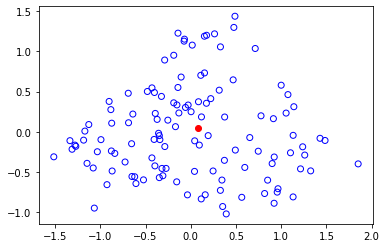

In [25]:
od.ordination_plot(od.pca_dct)

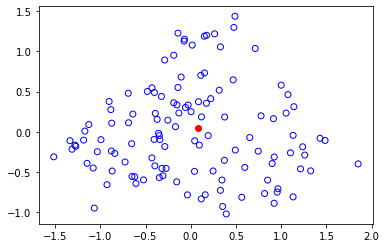

In [26]:
od.ordination_plot(od.kpca_dct)

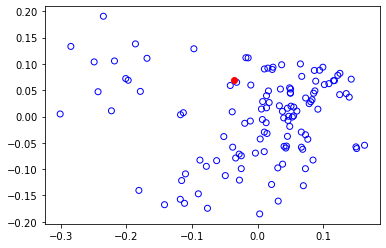

In [27]:
od.ordination_plot(od.pcoa_dct)

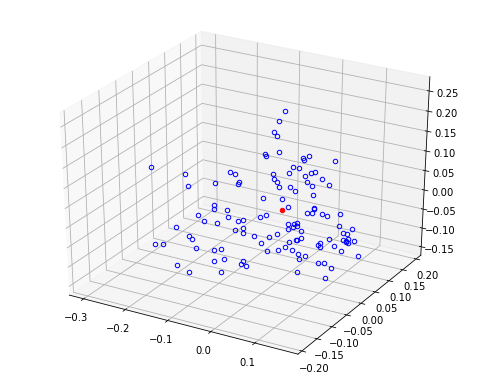

In [28]:
od.ordination_plot(od.pcoa_dct, n_axes=3)

In [29]:
od.pcoa_dct.keys()

dict_keys(['results', 'expl_var', 'sample_pos', 'pcoa_output'])

In [30]:
od.pcoa_dct['expl_var']

PC1    0.184440
PC2    0.116209
PC3    0.109386
dtype: float64

In [29]:
od.pcoa_dct['sample_pos'].to_csv("combined_bray_pcoa.tsv", 
                                 sep='\t', index_label='Index')

In [31]:
pcoa_cosine = od.calculate_pca(od.cosine_dist_mtrx, n_comp=3)

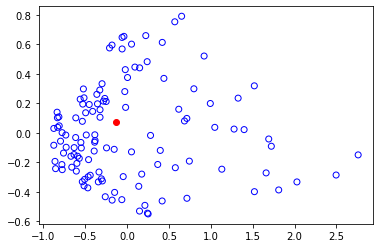

In [32]:
od.ordination_plot(pcoa_cosine)

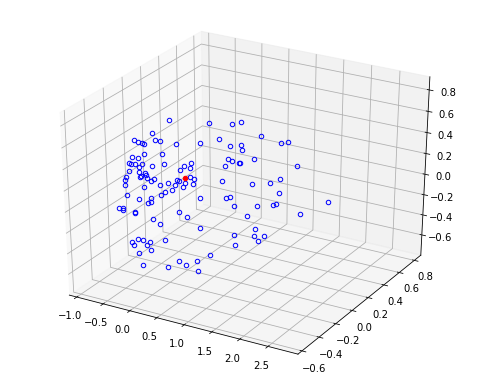

In [33]:
od.ordination_plot(pcoa_cosine, n_axes=3)

In [33]:
pcoa_cosine['sample_pos'].to_csv("combined_cosine_pcoa.tsv", 
                                 sep='\t', index_label='Index')

In [34]:
pcoa_cosine['expl_var']

array([0.62350125, 0.10541773, 0.09098851])

## Braycurtis PCoA plot

In [333]:
amd="""Ga0170573
Ga0173609
Ga0010914
Ga0136806
Ga0010913
Ga0136821
Ga0242604
Ga0212044
Ga0185299
Ga0102924
Ga0242602
Ga0188167
Ga0189856
Ga0052267
Ga0188182
Ga0052266
Ga0026418
"""
amd=amd.split()

In [334]:
amd

['Ga0170573',
 'Ga0173609',
 'Ga0010914',
 'Ga0136806',
 'Ga0010913',
 'Ga0136821',
 'Ga0242604',
 'Ga0212044',
 'Ga0185299',
 'Ga0102924',
 'Ga0242602',
 'Ga0188167',
 'Ga0189856',
 'Ga0052267',
 'Ga0188182',
 'Ga0052266',
 'Ga0026418']

In [335]:
tundra_arctic="""Ga0073583
Ga0185143
Ga0156901
Ga0075519
Ga0311337
Ga0491191
Ga0022196
Ga0302191
Ga0198867
Ga0302198
Ga0022193
Ga0209881
Ga0075530
Ga0182824
Ga0182875
Ga0209176
Ga0302119
Ga0209501
Ga0167665
Ga0302220
Ga0209890
Ga0311372
Ga0167657
Ga0310124
Ga0428435
Ga0209905
Ga0372821
Ga0208078
Ga0182018
Ga0209910
Ga0209871
Ga0486823
Ga0120109
Ga0075526
Ga0012981
Ga0011178
"""
tundra_arctic=tundra_arctic.split()

In [336]:
shale_fracking="""Ga0484792
Ga0310148
Ga0182237
Ga0310138
Ga0168647
Ga0482163
Ga0114984
Ga0484790
Ga0377190
Ga0484791
Ga0377191
Ga0482149
Ga0482151
Ga0233392
""".split()

In [337]:
cave = """Ga0451493
Ga0451492
Ga0451490
Ga0401342
Ga0436429
Ga0436433
Ga0451489
Ga0023037
Ga0011115
Ga0187893
Ga0187892
Ga0247727
Ga0213870
Ga0011319
Ga0011318
Ga0011301
Ga0187846
Ga0011321
Ga0011208
Ga0011089
Ga0064592
""".split()

In [338]:
contam_hydrocarb="""
Ga0011577
Ga0012390
Ga0074127
Ga0255841
Ga0159060
Ga0209514
""".split()


In [339]:
contam = """
Ga0010857
Ga0455824
Ga0400556
Ga0395784
Ga0209210
""".split()

In [340]:
import numpy as np
import matplotlib
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D, proj3d
import matplotlib.pyplot as plt
import matplotlib as mpl

def ordination_plot_3d(ordination_dct, tax_id_lst, target_idx_lst=[], expl_var=[], amd_lst=[], arct_lst=[]):
    SMALL_SIZE = 16
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 18
    axlabs = []
    for i in range(3):
        axlabs.append("PCo"+str(i+1))
        if len(expl_var)==3:
            axlabs[i] = axlabs[i]+" ("+str(round(expl_var[i]*100, 1))+"%)"
    print(axlabs)
        
    #mpl.rcParams['axes.linewidth'] = 0.1
    rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    #rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    rc('axes', labelsize=BIGGER_SIZE, linewidth=2)    # fontsize of the x and y labels
    rc('xtick', labelsize=SMALL_SIZE, c='k')    # fontsize of the tick labels
    #rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    mpl.rcParams['xtick.major.size'] = 1
    mpl.rcParams['xtick.major.width'] = 1
    
    #mpl.rcParams['xtick.minor.size'] = 10
    #mpl.rcParams['xtick.minor.width'] = 2
    
    rc('font',**{'family':'serif','serif':['Arial']})
    #rc('text', usetex=True)

    #rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
    #ax = plt.axes()
    pos = ordination_dct['results']
    #fig = plt.figure(figsize=(8.4, 6.8))
    fig = plt.figure(figsize=(12,10))
    #fig.subplots_adjust(top=1.1, bottom=-.1)
    ax = fig.add_subplot(111, projection='3d')
    #[x.set_linewidth(2) for x in ax.spines.values()]
    #ax.scatter(pos[:,0], pos[:,1], pos[:,2], facecolor=(0,0,0,0), edgecolor='b')
    #ax.set_facecolor('none')
    for idx,tax_id in zip(range(np.shape(ordination_dct['results'])[0]), tax_id_lst):
        if tax_id in target_idx_lst:
            ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], c='r', edgecolor='r') 
        elif tax_id in amd_lst:
            ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
                       facecolor=(0,0,0,0), edgecolor='orange', marker='^') 
        elif tax_id in arct_lst:
            ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
                       facecolor=(0,0,0,0), edgecolor='grey', marker='D') 
        else:
            ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], facecolor=(0,0,0,0), edgecolor='b') 
    
    ax.tick_params(direction='in', length=0, width=0, grid_alpha=0.5, color='k', labelsize='small', pad=8)
    #ax.zaxis.set_tick_params(direction='in', color='b')

    ax.set_zticks([-0.15, -0.05, 0.05,  0.15, 0.25])
    ax.set_yticks([-0.2, -0.1, 0,  0.1, 0.2])
    ax.set_xlabel(axlabs[0], rotation=-12, labelpad=12)
    ax.set_ylabel(axlabs[1], rotation=54, labelpad=12)
    ax.set_zlabel(axlabs[2], rotation=90, labelpad=12)
    
    #dummy plot to show legend
#     scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
#     scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='y', marker = 'v')
#     ax.legend([scatter1_proxy, scatter2_proxy], ['label1', 'label2'], numpoints = 1, )
    
    #plt.legend(loc="upper right")
    
    plt.show()

['PCo1 (18.4%)', 'PCo2 (11.6%)', 'PCo3 (10.9%)']


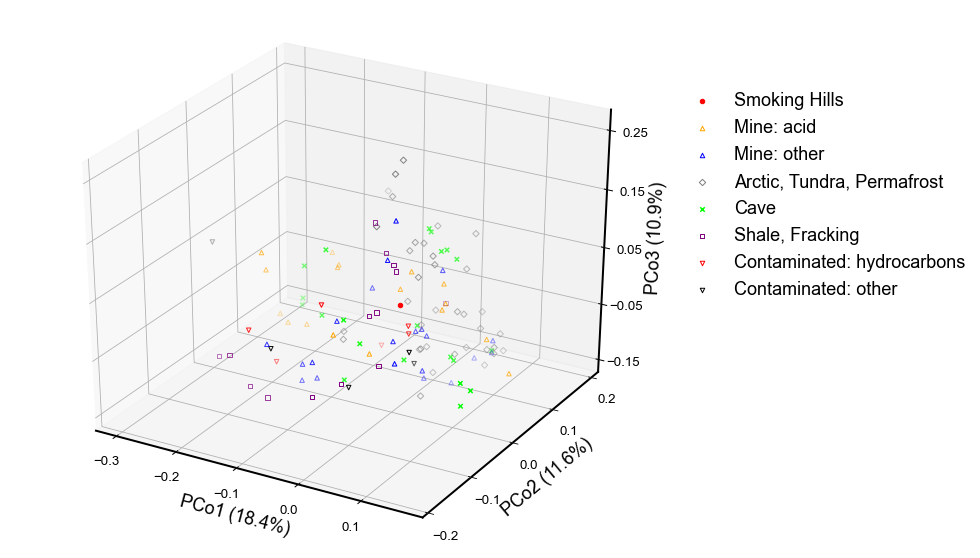

In [341]:
from collections import defaultdict

ordination_dct = od.pcoa_dct
expl_var = od.pcoa_dct['expl_var']
amd_lst = amd
arct_lst = tundra_arctic
tax_id_lst = od.pcoa_dct['sample_pos']['taxon_oid'].to_list()
target_idx_lst=["Ga0495008"]

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
axlabs = []
for i in range(3):
    axlabs.append("PCo"+str(i+1))
    if len(expl_var)==3:
        axlabs[i] = axlabs[i]+" ("+str(round(expl_var[i]*100, 1))+"%)"
print(axlabs)

#mpl.rcParams['axes.linewidth'] = 0.1
rc('font', size=MEDIUM_SIZE)          # controls default text sizes
#rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
rc('axes', labelsize=BIGGER_SIZE, linewidth=2)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE, c='k')    # fontsize of the tick labels
#rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams['xtick.major.size'] = 1
mpl.rcParams['xtick.major.width'] = 1

#mpl.rcParams['xtick.minor.size'] = 10
#mpl.rcParams['xtick.minor.width'] = 2

rc('font',**{'family':'serif','serif':['Arial']})
#rc('text', usetex=True)

#rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#ax = plt.axes()
pos = ordination_dct['results']
#fig = plt.figure(figsize=(8.4, 6.8))
fig = plt.figure(figsize=(12,10))
#fig.subplots_adjust(top=1.1, bottom=-.1)
ax = fig.add_subplot(111, projection='3d')
#[x.set_linewidth(2) for x in ax.spines.values()]
#ax.scatter(pos[:,0], pos[:,1], pos[:,2], facecolor=(0,0,0,0), edgecolor='b')
#ax.set_facecolor('none')
data_id = defaultdict(list)
# data_id['target'] = defaultdict(list)
# data_id['acid'] = defaultdict(list)
# data_id['arctic'] = defaultdict(list)
# data_id['other'] = defaultdict(list)

for idx,tax_id in zip(range(np.shape(ordination_dct['results'])[0]), tax_id_lst):
    if tax_id in target_idx_lst:
        data_id['target'].append(idx)
        #ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], c='r', edgecolor='r') 
    elif tax_id in amd_lst:
        data_id['acid'].append(idx)
#         ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
#                    facecolor=(0,0,0,0), edgecolor='orange', marker='^', label="Acid Mine") 
    elif tax_id in arct_lst:
        data_id['arctic'].append(idx)
#         ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
#                    facecolor=(0,0,0,0), edgecolor='grey', marker='D') 
    elif tax_id in shale_fracking:
        data_id['shale_frac'].append(idx)
    elif tax_id in cave:
        data_id['cave'].append(idx)
    elif tax_id in contam_hydrocarb:
        data_id['contam_hydrocarb'].append(idx)
    elif tax_id in contam:
        data_id['contam'].append(idx)
    else:
        data_id['other'].append(idx)
        #ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], facecolor=(0,0,0,0), edgecolor='b') 

axis = 0
arctic_data = np.take(pos, data_id['arctic'], axis)        
target_data = np.take(pos, data_id['target'], axis)        
other_data = np.take(pos, data_id['other'], axis)        
acid_data = np.take(pos, data_id['acid'], axis)  
shale_fr_data = np.take(pos, data_id['shale_frac'], axis)  
cave_data = np.take(pos, data_id['cave'], axis)  
contam_data = np.take(pos, data_id['contam'], axis)  
contam_hydrocarb_data = np.take(pos, data_id['contam_hydrocarb'], axis)  



ax.scatter(target_data[:,0], target_data[:,1], target_data[:,2],
           edgecolor='r', marker='o', c='r', label="Smoking Hills")
ax.scatter(acid_data[:,0], acid_data[:,1], acid_data[:,2],
           facecolor=(0,0,0,0), edgecolor='orange', marker='^', label="Mine: acid")
ax.scatter(other_data[:,0], other_data[:,1], other_data[:,2],
           facecolor=(0,0,0,0),edgecolor='b',marker='^', label="Mine: other")
ax.scatter(arctic_data[:,0], arctic_data[:,1], arctic_data[:,2],
           facecolor=(0,0,0,0),edgecolor='grey', marker='D', label="Arctic, Tundra, Permafrost")
ax.scatter(cave_data[:,0], cave_data[:,1], cave_data[:,2],
           edgecolor='lime', marker='x', label="Cave", c='lime')
ax.scatter(shale_fr_data[:,0], shale_fr_data[:,1], shale_fr_data[:,2],
           facecolor=(0,0,0,0),edgecolor='purple', marker='s', label="Shale, Fracking")
ax.scatter(contam_hydrocarb_data[:,0], contam_hydrocarb_data[:,1], contam_hydrocarb_data[:,2],
           facecolor=(0,0,0,0),edgecolor='r',marker='v', label="Contaminated: hydrocarbons")
ax.scatter(contam_data[:,0], contam_data[:,1], contam_data[:,2],
           facecolor=(0,0,0,0),edgecolor='k',marker='v', label="Contaminated: other")


ax.tick_params(direction='in', length=0, width=0, grid_alpha=0.5, color='k', labelsize='small', pad=8)
#ax.zaxis.set_tick_params(direction='in', color='b')

ax.set_zticks([-0.15, -0.05, 0.05,  0.15, 0.25])
ax.set_yticks([-0.2, -0.1, 0,  0.1, 0.2])
ax.set_xlabel(axlabs[0], rotation=-12, labelpad=12)
ax.set_ylabel(axlabs[1], rotation=54, labelpad=12)
ax.set_zlabel(axlabs[2], rotation=90, labelpad=12)

#dummy plot to show legend
#     scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
#     scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='y', marker = 'v')
#     ax.legend([scatter1_proxy, scatter2_proxy], ['label1', 'label2'], numpoints = 1, )

ax.legend(loc=(1.,0.45),frameon=0)
#plt.legend()
plt.savefig('sh11_cog_ordination.svg', format='svg', dpi=1000, bbox_inches = 'tight')
plt.savefig('sh11_cog_ordination.png', format='png', dpi=1000, bbox_inches = 'tight')
plt.savefig('sh11_cog_ordination.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

plt.show()

In [352]:
mpl.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

## Bray-curtis pcoa 2d

['PCo1 (18.4%)', 'PCo2 (11.6%)', 'PCo3 (10.9%)']


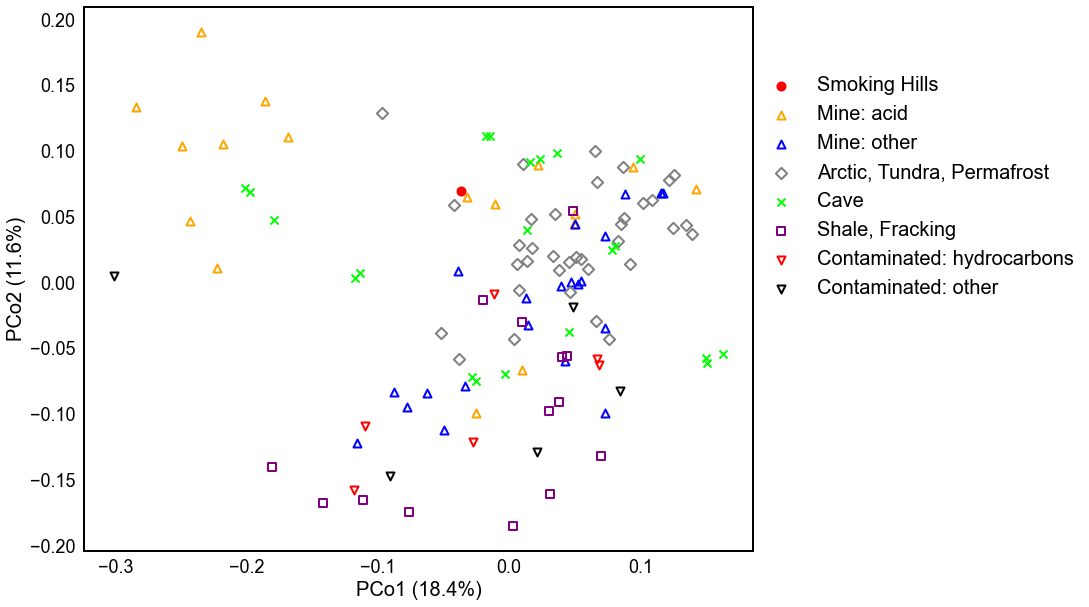

In [357]:
from collections import defaultdict
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 8
#mpl.rcParams['lines.markeredgewidth'] = 2

ordination_dct = od.pcoa_dct
expl_var = od.pcoa_dct['expl_var']
amd_lst = amd
arct_lst = tundra_arctic
tax_id_lst = od.pcoa_dct['sample_pos']['taxon_oid'].to_list()
target_idx_lst=["Ga0495008"]

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
axlabs = []
for i in range(3):
    axlabs.append("PCo"+str(i+1))
    if len(expl_var)==3:
        axlabs[i] = axlabs[i]+" ("+str(round(expl_var[i]*100, 1))+"%)"
print(axlabs)

#mpl.rcParams['axes.linewidth'] = 0.1
rc('font', size=MEDIUM_SIZE)          # controls default text sizes
#rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
rc('axes', labelsize=BIGGER_SIZE, linewidth=2)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE, c='k')    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams['xtick.major.size'] = 1
mpl.rcParams['xtick.major.width'] = 1

#mpl.rcParams['xtick.minor.size'] = 10
#mpl.rcParams['xtick.minor.width'] = 2

rc('font',**{'family':'serif','serif':['Arial']})
#rc('text', usetex=True)

#rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#ax = plt.axes()
pos = ordination_dct['results']
#fig = plt.figure(figsize=(8.4, 6.8))
fig = plt.figure(figsize=(12,10))
#fig.subplots_adjust(top=1.1, bottom=-.1)
ax = fig.add_subplot(111)#, projection='3d')
#[x.set_linewidth(2) for x in ax.spines.values()]
#ax.scatter(pos[:,0], pos[:,1], pos[:,2], facecolor=(0,0,0,0), edgecolor='b')
#ax.set_facecolor('none')
data_id = defaultdict(list)
# data_id['target'] = defaultdict(list)
# data_id['acid'] = defaultdict(list)
# data_id['arctic'] = defaultdict(list)
# data_id['other'] = defaultdict(list)

for idx,tax_id in zip(range(np.shape(ordination_dct['results'])[0]), tax_id_lst):
    if tax_id in target_idx_lst:
        data_id['target'].append(idx)
        #ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], c='r', edgecolor='r') 
    elif tax_id in amd_lst:
        data_id['acid'].append(idx)
#         ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
#                    facecolor=(0,0,0,0), edgecolor='orange', marker='^', label="Acid Mine") 
    elif tax_id in arct_lst:
        data_id['arctic'].append(idx)
#         ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
#                    facecolor=(0,0,0,0), edgecolor='grey', marker='D') 
    elif tax_id in shale_fracking:
        data_id['shale_frac'].append(idx)
    elif tax_id in cave:
        data_id['cave'].append(idx)
    elif tax_id in contam_hydrocarb:
        data_id['contam_hydrocarb'].append(idx)
    elif tax_id in contam:
        data_id['contam'].append(idx)
    else:
        data_id['other'].append(idx)
        #ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], facecolor=(0,0,0,0), edgecolor='b') 

axis = 0
arctic_data = np.take(pos, data_id['arctic'], axis)        
target_data = np.take(pos, data_id['target'], axis)        
other_data = np.take(pos, data_id['other'], axis)        
acid_data = np.take(pos, data_id['acid'], axis)  
shale_fr_data = np.take(pos, data_id['shale_frac'], axis)  
cave_data = np.take(pos, data_id['cave'], axis)  
contam_data = np.take(pos, data_id['contam'], axis)  
contam_hydrocarb_data = np.take(pos, data_id['contam_hydrocarb'], axis)  



ax.scatter(target_data[:,0], target_data[:,1],
           edgecolor='r', marker='o', c='r', 
           label="Smoking Hills", linewidth=2)
ax.scatter(acid_data[:,0], acid_data[:,1],
           facecolor=(0,0,0,0), edgecolor='orange', 
           marker='^', label="Mine: acid", linewidth=2)
ax.scatter(other_data[:,0], other_data[:,1],
           facecolor=(0,0,0,0),edgecolor='b',marker='^', 
           label="Mine: other", linewidth=2)
ax.scatter(arctic_data[:,0], arctic_data[:,1], 
           facecolor=(0,0,0,0),edgecolor='grey', marker='D',
           label="Arctic, Tundra, Permafrost", linewidth=2)
ax.scatter(cave_data[:,0], cave_data[:,1],
           edgecolor='lime', marker='x', 
           label="Cave", c='lime', linewidth=2)
ax.scatter(shale_fr_data[:,0], shale_fr_data[:,1],
           facecolor=(0,0,0,0),edgecolor='purple', marker='s', 
           label="Shale, Fracking", linewidth=2)
ax.scatter(contam_hydrocarb_data[:,0], contam_hydrocarb_data[:,1],
           facecolor=(0,0,0,0),edgecolor='r',marker='v', 
           label="Contaminated: hydrocarbons", linewidth=2)
ax.scatter(contam_data[:,0], contam_data[:,1],
           facecolor=(0,0,0,0),edgecolor='k',marker='v',
           label="Contaminated: other", linewidth=2)


ax.tick_params(direction='in', length=0, width=0, grid_alpha=0.5, color='k', labelsize='medium', pad=8)
#ax.zaxis.set_tick_params(direction='in', color='b')

#ax.set_zticks([-0.15, -0.05, 0.05,  0.15, 0.25])
#ax.set_yticks([-0.2, -0.1, 0,  0.1, 0.2])
ax.set_xlabel(axlabs[0])#, rotation=-12, labelpad=12)
ax.set_ylabel(axlabs[1])#, rotation=54, labelpad=12)
#ax.set_zlabel(axlabs[2], rotation=90, labelpad=12)

#dummy plot to show legend
#     scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
#     scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='y', marker = 'v')
#     ax.legend([scatter1_proxy, scatter2_proxy], ['label1', 'label2'], numpoints = 1, )

ax.legend(loc=(1.,0.45),frameon=0)
#plt.legend()
plt.savefig('sh11_cog_ordination_2d.svg', format='svg', dpi=1000, bbox_inches = 'tight')
plt.savefig('sh11_cog_ordination_2d.png', format='png', dpi=1000, bbox_inches = 'tight')
plt.savefig('sh11_cog_ordination_2d.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

plt.show()

## Cosine ordination

['PCo1 (62.4%)', 'PCo2 (10.5%)', 'PCo3 (9.1%)']


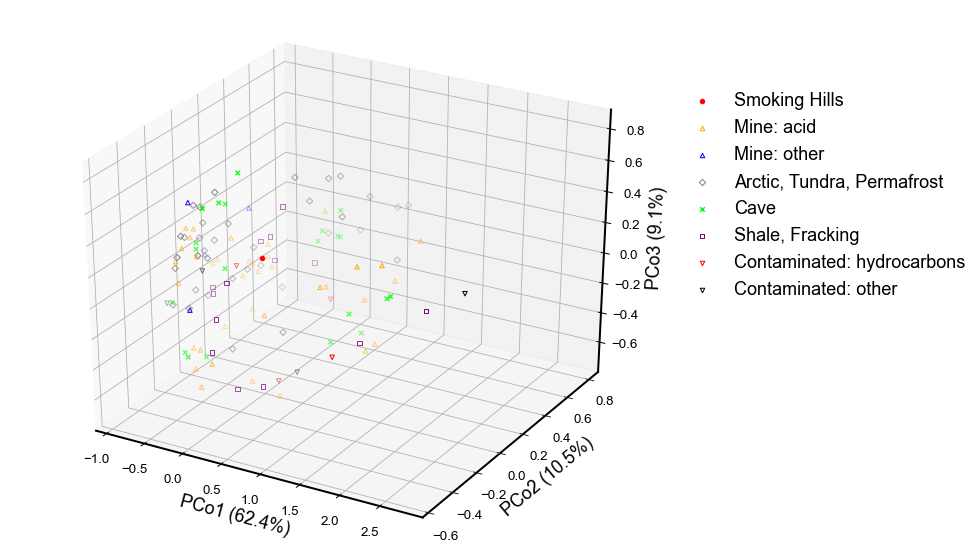

In [301]:
from collections import defaultdict

ordination_dct = pcoa_cosine
expl_var = pcoa_cosine['expl_var']
amd_lst = amd
arct_lst = tundra_arctic
tax_id_lst = pcoa_cosine['sample_pos']['taxon_oid'].to_list()
target_idx_lst=["Ga0495008"]

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
axlabs = []
for i in range(3):
    axlabs.append("PCo"+str(i+1))
    if len(expl_var)==3:
        axlabs[i] = axlabs[i]+" ("+str(round(expl_var[i]*100, 1))+"%)"
print(axlabs)

#mpl.rcParams['axes.linewidth'] = 0.1
rc('font', size=MEDIUM_SIZE)          # controls default text sizes
#rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
rc('axes', labelsize=BIGGER_SIZE, linewidth=2)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE, c='k')    # fontsize of the tick labels
#rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams['xtick.major.size'] = 1
mpl.rcParams['xtick.major.width'] = 1

#mpl.rcParams['xtick.minor.size'] = 10
#mpl.rcParams['xtick.minor.width'] = 2

rc('font',**{'family':'serif','serif':['Arial']})
#rc('text', usetex=True)

#rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#ax = plt.axes()
pos = ordination_dct['results']
#fig = plt.figure(figsize=(8.4, 6.8))
fig = plt.figure(figsize=(12,10))
#fig.subplots_adjust(top=1.1, bottom=-.1)
ax = fig.add_subplot(111, projection='3d')
#[x.set_linewidth(2) for x in ax.spines.values()]
#ax.scatter(pos[:,0], pos[:,1], pos[:,2], facecolor=(0,0,0,0), edgecolor='b')
#ax.set_facecolor('none')
data_id = defaultdict(list)
# data_id['target'] = defaultdict(list)
# data_id['acid'] = defaultdict(list)
# data_id['arctic'] = defaultdict(list)
# data_id['other'] = defaultdict(list)

for idx,tax_id in zip(range(np.shape(ordination_dct['results'])[0]), tax_id_lst):
    if tax_id in target_idx_lst:
        data_id['target'].append(idx)
        #ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], c='r', edgecolor='r') 
    elif tax_id in amd_lst:
        data_id['acid'].append(idx)
#         ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
#                    facecolor=(0,0,0,0), edgecolor='orange', marker='^', label="Acid Mine") 
    elif tax_id in arct_lst:
        data_id['arctic'].append(idx)
#         ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], 
#                    facecolor=(0,0,0,0), edgecolor='grey', marker='D') 
    elif tax_id in shale_fracking:
        data_id['shale_frac'].append(idx)
    elif tax_id in cave:
        data_id['cave'].append(idx)
    elif tax_id in contam_hydrocarb:
        data_id['contam_hydrocarb'].append(idx)
    elif tax_id in contam:
        data_id['contam'].append(idx)
    else:
        data_id['other'].append(idx)
        #ax.scatter(pos[idx][0], pos[idx][1], pos[idx][2], facecolor=(0,0,0,0), edgecolor='b') 

axis = 0
arctic_data = np.take(pos, data_id['arctic'], axis)        
target_data = np.take(pos, data_id['target'], axis)        
other_data = np.take(pos, data_id['other'], axis)        
acid_data = np.take(pos, data_id['acid'], axis)  
shale_fr_data = np.take(pos, data_id['shale_frac'], axis)  
cave_data = np.take(pos, data_id['cave'], axis)  
contam_data = np.take(pos, data_id['contam'], axis)  
contam_hydrocarb_data = np.take(pos, data_id['contam_hydrocarb'], axis)  



ax.scatter(target_data[:,0], target_data[:,1], target_data[:,2],
           edgecolor='r', marker='o', c='r', label="Smoking Hills")
ax.scatter(acid_data[:,0], acid_data[:,1], acid_data[:,2],
           facecolor=(0,0,0,0), edgecolor='orange', marker='^', label="Mine: acid")
ax.scatter(other_data[:,0], other_data[:,1], other_data[:,2],
           facecolor=(0,0,0,0),edgecolor='b',marker='^', label="Mine: other")
ax.scatter(arctic_data[:,0], arctic_data[:,1], arctic_data[:,2],
           facecolor=(0,0,0,0),edgecolor='grey', marker='D', label="Arctic, Tundra, Permafrost")
ax.scatter(cave_data[:,0], cave_data[:,1], cave_data[:,2],
           edgecolor='lime', marker='x', label="Cave", c='lime')
ax.scatter(shale_fr_data[:,0], shale_fr_data[:,1], shale_fr_data[:,2],
           facecolor=(0,0,0,0),edgecolor='purple', marker='s', label="Shale, Fracking")
ax.scatter(contam_hydrocarb_data[:,0], contam_hydrocarb_data[:,1], contam_hydrocarb_data[:,2],
           facecolor=(0,0,0,0),edgecolor='r',marker='v', label="Contaminated: hydrocarbons")
ax.scatter(contam_data[:,0], contam_data[:,1], contam_data[:,2],
           facecolor=(0,0,0,0),edgecolor='k',marker='v', label="Contaminated: other")


ax.tick_params(direction='in', length=0, width=0, grid_alpha=0.5, color='k', labelsize='small', pad=8)
#ax.zaxis.set_tick_params(direction='in', color='b')

# ax.set_zticks([-0.15, -0.05, 0.05,  0.15, 0.25])
# ax.set_yticks([-0.2, -0.1, 0,  0.1, 0.2])
ax.set_xlabel(axlabs[0], rotation=-12, labelpad=12)
ax.set_ylabel(axlabs[1], rotation=54, labelpad=12)
ax.set_zlabel(axlabs[2], rotation=90, labelpad=12)

#dummy plot to show legend
#     scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
#     scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='y', marker = 'v')
#     ax.legend([scatter1_proxy, scatter2_proxy], ['label1', 'label2'], numpoints = 1, )

ax.legend(loc=(1.,0.45),frameon=0)
#plt.legend()
# plt.savefig('sh11_cog_ordination.svg', format='svg', dpi=1000, bbox_inches = 'tight')
# plt.savefig('sh11_cog_ordination.png', format='png', dpi=1000, bbox_inches = 'tight')
# plt.savefig('sh11_cog_ordination.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

plt.show()

In [251]:
arctic_data[:,0]

array([-0.09719043,  0.06508714,  0.00572836,  0.00717801, -0.03808769,
       -0.05163204,  0.01019545,  0.01342987,  0.08633345,  0.00384491,
        0.08522569,  0.08280757,  0.10851258,  0.0549206 ,  0.05074949,
        0.07637427,  0.05968138,  0.10160277,  0.03306131,  0.00758064,
        0.12207753,  0.0453528 ,  0.12490186,  0.03463885,  0.06712496,
        0.0174594 ,  0.03771362,  0.09174831,  0.13949011,  0.01641525,
        0.06644799,  0.13488595, -0.04177823,  0.08720589,  0.12532653,
        0.04625037])

In [241]:
data_id['arctic']

defaultdict(list, {})

['PCo1 (18.4%)', 'PCo2 (11.6%)', 'PCo3 (10.9%)']


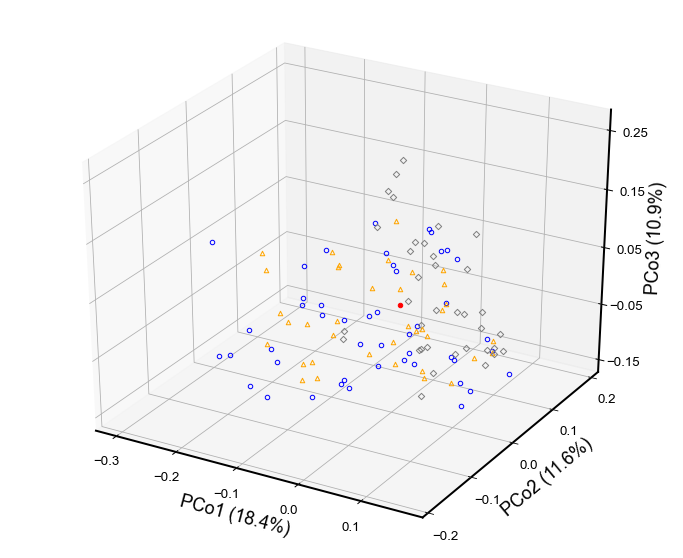

In [280]:
ordination_plot_3d(od.pcoa_dct, od.pcoa_dct['sample_pos']['taxon_oid'].to_list(),
                   target_idx_lst=["Ga0495008"], expl_var=od.pcoa_dct['expl_var'], 
                   amd_lst=amd, arct_lst=tundra_arctic)

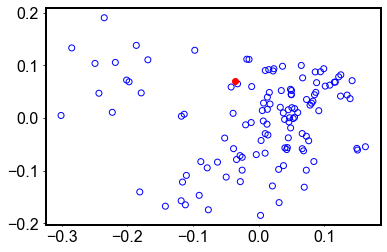

In [225]:
od.ordination_plot(od.pcoa_dct)

## Tests checkups

In [ ]:
pd.DataFrame.sort_values()

In [ ]:
ms.export_meta_similarity('2_mg_ms2_w_md.tsv', w_metadata=True)

In [309]:
ms.get_meta_similarity_w_metadata(by_taxon_oid=False).sort_values(by=['IMG Genome ID '])

,taxon_oid,cosine_to_target,braycurtis_to_target,correlation_to_target,jaccard_to_target,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,IMG Genome ID,GOLD Analysis Project ID,Genome Size * assembled,Gene Count * assembled
1,Ga0495008,1.000000,1.000000,1.000000,1.000000,*Microbiome,Draft,Ultra-acidic sulfur-rich Arctic ponds from Smo...,Sediment microbial communites from ultra-acidi...,University of Calgary,3300045129,Ga0495008,184451886,396066
0,Ga0485835,0.740785,0.683907,0.684559,0.790755,*Microbiome,Permanent Draft,Sediment chemolithoautotrophic microbial commu...,Microbial mat bacterial communities from ripar...,DOE Joint Genome Institute (JGI),3300045855,Ga0485835,230811065,405490


In [217]:
ms.meta_similarity

,taxon_oid,cosine_to_target,braycurtis_to_target,correlation_to_target,jaccard_to_target
0,Ga0485835,1.000000,1.000000,1.000000,1.000000
1,Ga0495008,0.740785,0.683907,0.684559,0.790755


In [316]:
ms.get_meta_similarity_w_metadata().sort_values(by=['IMG Genome ID '])

,taxon_oid,cosine_to_target,braycurtis_to_target,correlation_to_target,jaccard_to_target,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,IMG Genome ID,GOLD Analysis Project ID,Genome Size * assembled,Gene Count * assembled
0,3300045129,1.000000,1.000000,1.000000,1.000000,*Microbiome,Draft,Ultra-acidic sulfur-rich Arctic ponds from Smo...,Sediment microbial communites from ultra-acidi...,University of Calgary,3300045129,Ga0495008,184451886,396066
1,3300045855,0.740785,0.683907,0.684559,0.790755,*Microbiome,Permanent Draft,Sediment chemolithoautotrophic microbial commu...,Microbial mat bacterial communities from ripar...,DOE Joint Genome Institute (JGI),3300045855,Ga0485835,230811065,405490


In [270]:
ms.meta_similarity.merge(ms.metadata_df.reset_index(drop=True), how='left', left_on='taxon_oid', right_on='GOLD Analysis Project ID')

,taxon_oid,cosine_to_target,braycurtis_to_target,correlation_to_target,jaccard_to_target,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,IMG Genome ID,GOLD Analysis Project ID,Genome Size * assembled,Gene Count * assembled
0,Ga0485835,1.000000,1.000000,1.000000,1.000000,*Microbiome,Permanent Draft,Sediment chemolithoautotrophic microbial commu...,Microbial mat bacterial communities from ripar...,DOE Joint Genome Institute (JGI),3300045855,Ga0485835,230811065,405490
1,Ga0495008,0.740785,0.683907,0.684559,0.790755,*Microbiome,Draft,Ultra-acidic sulfur-rich Arctic ponds from Smo...,Sediment microbial communites from ultra-acidi...,University of Calgary,3300045129,Ga0495008,184451886,396066


In [611]:
mg_to_filter = list(map(str, [3300042802, 3300046013]))
profiles = read_cog_profiles("../rel_mg_cogs/*.tsv", 
                             'coglist123340_25-mar-2018.tsv', min_cog_cutoff_pct=0.4, ids_to_filter=mg_to_filter)

3300033817
3300033886
3300033892
3300033998
3300034684
3300035000
3300035004
3300036493
3300036808
3300036814
3300036944
3300037256
3300037301
3300037381
3300037426
3300037483
3300038411
3300038412
3300038471
3300038493
3300038681
3300038731
3300039456
3300040733
3300040734
3300040958
3300041991
3300042143
3300042780
3300042781
3300042784
	Skipping: ../rel_mg_cogs/3300042802.tsv...
3300042808
3300042815
3300042991
3300043035
3300043039
3300043569
3300044940
3300044960
3300045129
3300045557
3300045789
3300045855
3300045918
3300045963
3300045973
	Skipping: ../rel_mg_cogs/3300046013.tsv...
3300046014
3300046467
3300047303
3300047305
3300047669
3300048618
3300048637
3300050330
3300050331
3300037502
3300042810


In [599]:
#profiles = convert_to_relative_counts(profiles)

In [978]:
od = Ordination(profiles, target_id=["3300045129"], metadata_path="36_mg_basic_metadata.tsv", by_taxon_oid=True,
               profile_metadata_path="coglist123340_25-mar-2018.tsv")

/home/andriy/anaconda3/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.830648647177805e-05 and the largest is 0.9439438739039911.
  warn(


In [979]:
dir(od.pcoa_dct)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [965]:
od.pcoa_dct['sample_pos'].to_csv('56_mg_bray_pcoa_w_some_md.tsv', sep='\t', index=False)

In [980]:
od.pcoa_dct['sample_pos']

,PC1,PC2,PC3,taxon_oid,angle,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,IMG Genome ID,GOLD Analysis Project ID,Genome Size * assembled,Gene Count * assembled
0,-0.139275,-0.036334,-0.080254,3300033817,-165.378760,*Microbiome,Permanent Draft,"Metagenomes from 1,2,4-trichlorobenzene dechlo...",Laboratory-enriched microbial communities from...,Beijing Genomics Institute (BGI),3.300034e+09,Ga0373875,1.906594e+08,324799.0
1,0.006252,0.069393,-0.057059,3300033886,84.852153,*Microbiome,Permanent Draft,Phototrophic mat microbial and viral communiti...,Hot spring phototrophic mat microbial communit...,DOE Joint Genome Institute (JGI),3.300034e+09,Ga0308413,3.940341e+08,806066.0
2,-0.268282,0.376072,0.066006,3300033892,125.503330,*Microbiome,Permanent Draft,Hot spring microbial communities from differen...,Hot spring water microbial communities from No...,DOE Joint Genome Institute (JGI),3.300034e+09,Ga0326767,8.496825e+07,172934.0
3,-0.229633,-0.046796,-0.116306,3300033998,-168.481712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.121059,-0.081291,-0.066342,3300034684,-146.118884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.105054,-0.073594,-0.020579,3300035000,-35.012820,*Microbiome,Permanent Draft,Terrestrial cyanobacterial communities with co...,Desmonostoc geniculatum HA4340-LM1 and co-occu...,DOE Joint Genome Institute (JGI),3.300035e+09,Ga0370518,6.540888e+07,85450.0
6,0.100945,-0.105560,0.081165,3300035004,-46.280062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.145125,0.081632,-0.064551,3300036493,29.357599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.096881,0.078883,-0.051631,3300036808,39.153061,*Microbiome,Permanent Draft,Marine microbial communities from Western Arct...,Marine microbial communities from Western Arct...,DOE Joint Genome Institute (JGI),3.300037e+09,Ga0302124,1.537729e+09,2579196.0
9,0.088766,0.097094,-0.049957,3300036814,47.565454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [967]:
od.pcoa_dct

{'results': array([[-1.39275347e-01, -3.63336502e-02, -8.02539844e-02],
        [ 6.25153223e-03,  6.93925208e-02, -5.70589510e-02],
        [-2.68282178e-01,  3.76071508e-01,  6.60055344e-02],
        [-2.29633466e-01, -4.67957904e-02, -1.16306064e-01],
        [-1.21059252e-01, -8.12905378e-02, -6.63421171e-02],
        [ 1.05053759e-01, -7.35944705e-02, -2.05791838e-02],
        [ 1.00945288e-01, -1.05559642e-01,  8.11653681e-02],
        [ 1.45124986e-01,  8.16322909e-02, -6.45508890e-02],
        [ 9.68814813e-02,  7.88825333e-02, -5.16308000e-02],
        [ 8.87660767e-02,  9.70936246e-02, -4.99573663e-02],
        [ 3.16022650e-02, -6.70198798e-02,  1.41019184e-02],
        [ 1.29566332e-01,  5.78828998e-02, -8.98770342e-03],
        [ 1.28375906e-01,  5.32227619e-02, -5.53510056e-03],
        [ 7.51896352e-03,  5.37061077e-02, -4.49977097e-02],
        [ 3.00115536e-02,  5.34238863e-03, -3.43242605e-02],
        [ 6.08217440e-02,  6.44905253e-03, -9.93915692e-03],
        [ 1.6

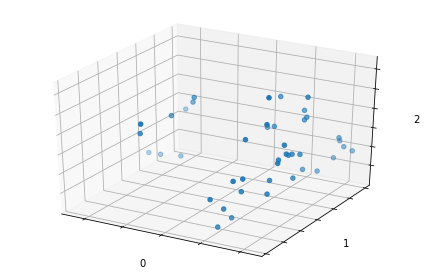

In [32]:
od.pcoa_dct["pcoa_output"]

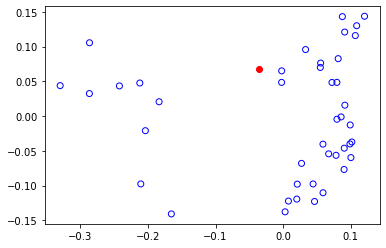

In [33]:
od.ordination_plot(od.pcoa_dct)

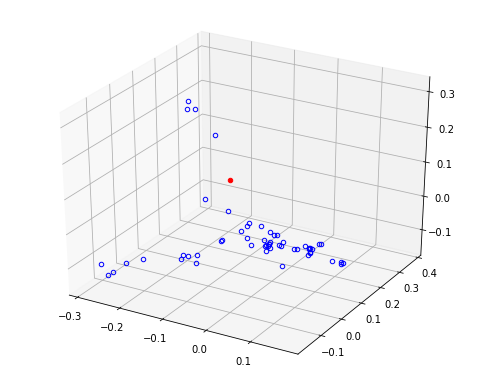

In [982]:
od.ordination_plot(od.pcoa_dct, n_axes=3)

In [913]:
od.cosine_dist_mtrx.tofile('cosine_mtrx.csv',sep=',',format='%10.5f')


In [971]:
pcoa_cosine = od.calculate_pca(od.cosine_dist_mtrx, n_comp=3)


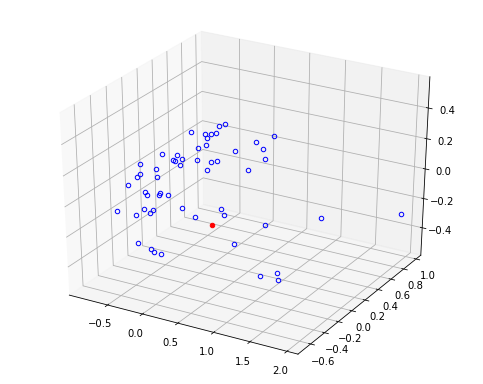

In [973]:
od.ordination_plot_3d(pcoa_cosine)

In [974]:
pcoa_cosine_2d = od.calculate_pca(od.cosine_dist_mtrx, n_comp=2)

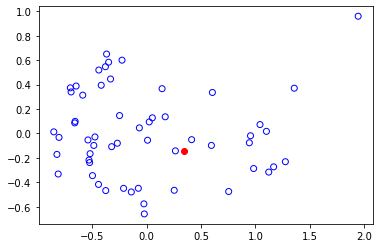

In [975]:
od.ordination_plot(pcoa_cosine_2d)

In [928]:
pcoa_cosine_2d['sample_pos'].to_csv("56_mg_cosine_pcoa_2d_w_some_md.tsv", sep='\t', index=False)

In [922]:
pcoa_cosine['sample_pos'].to_csv("56_mg_cosine_pcoa_3d_w_some_md.tsv", sep='\t', index=False)

In [910]:
od.bray_dist_mtrx

array([[0.        , 0.37566315, 0.63455461, ..., 0.36848203, 0.39248969,
        0.33966965],
       [0.37566315, 0.        , 0.63436168, ..., 0.37928454, 0.43388436,
        0.35421486],
       [0.63455461, 0.63436168, 0.        , ..., 0.67179784, 0.70696416,
        0.67073184],
       ...,
       [0.36848203, 0.37928454, 0.67179784, ..., 0.        , 0.38292533,
        0.28783545],
       [0.39248969, 0.43388436, 0.70696416, ..., 0.38292533, 0.        ,
        0.38005216],
       [0.33966965, 0.35421486, 0.67073184, ..., 0.28783545, 0.38005216,
        0.        ]])

In [890]:
pca_3 = od.calculate_pca(n_comp=3)


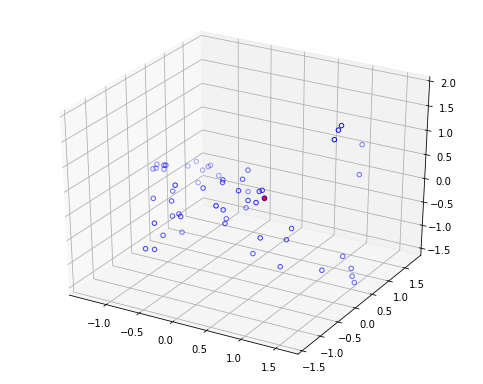

In [892]:
od.ordination_plot(pca_3, n_axes=3)

In [894]:
pca_3["sample_pos"].to_csv('56_mg_bray_pca_3d_w_some_md.tsv', sep='\t', index=False)

In [637]:
od.pcoa_dct.proportion_explained

PC1     0.215699
PC2     0.136177
PC3     0.109557
PC4     0.075380
PC5     0.063547
PC6     0.044174
PC7     0.040607
PC8     0.032822
PC9     0.027050
PC10    0.024257
PC11    0.021015
PC12    0.018991
PC13    0.018419
PC14    0.016024
PC15    0.014328
PC16    0.014132
PC17    0.011379
PC18    0.010048
PC19    0.009171
PC20    0.008786
PC21    0.007302
PC22    0.006900
PC23    0.006024
PC24    0.005936
PC25    0.005307
PC26    0.005209
PC27    0.005153
PC28    0.004319
PC29    0.004192
PC30    0.003561
PC31    0.003401
PC32    0.003050
PC33    0.002925
PC34    0.002700
PC35    0.002674
PC36    0.002349
PC37    0.002232
PC38    0.002008
PC39    0.001937
PC40    0.001618
PC41    0.001545
PC42    0.001340
PC43    0.001242
PC44    0.001166
PC45    0.001080
PC46    0.000819
PC47    0.000615
PC48    0.000404
PC49    0.000353
PC50    0.000296
PC51    0.000270
PC52    0.000247
PC53    0.000151
PC54    0.000075
PC55    0.000034
PC56    0.000000
PC57    0.000000
dtype: float64

In [647]:
od.pcoa_dct.samples.iloc[:,0:3]

,PC1,PC2,PC3
0,-0.139275,-0.036334,-0.080254
1,0.006252,0.069393,-0.057059
2,-0.268282,0.376072,0.066006
3,-0.229633,-0.046796,-0.116306
4,-0.121059,-0.081291,-0.066342
5,0.105054,-0.073594,-0.020579
6,0.100945,-0.105560,0.081165
7,0.145125,0.081632,-0.064551
8,0.096881,0.078883,-0.051631
9,0.088766,0.097094,-0.049957


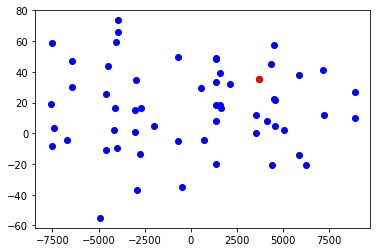

In [622]:
kpca_dct = od.calculate_kpca(profiles, kernel='linear')
od.ordination_plot(kpca_dct)

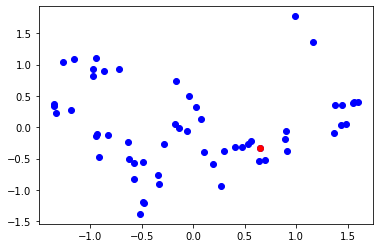

In [604]:
od.ordination_plot(od.pca_dct)

In [202]:
re

,taxon_oid,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0008,COG0009,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,COG5665
0,2006543007,7.0,3.0,0.0,4.0,4.0,10.0,4.0,11.0,3.0,...,0.0,3.0,0.0,10.0,0.0,0.0,2.0,0.0,0.0,0.0
1,2007427000,63.0,34.0,14.0,49.0,32.0,88.0,28.0,116.0,44.0,...,3.0,0.0,1.0,14.0,1.0,0.0,31.0,1.0,0.0,0.0
2,2010484004,13.0,7.0,15.0,8.0,9.0,33.0,2.0,14.0,20.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013515001,20.0,8.0,4.0,9.0,10.0,30.0,13.0,17.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013954001,12.0,10.0,4.0,4.0,9.0,11.0,6.0,7.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,3300045129,89.0,70.0,95.0,119.0,36.0,145.0,55.0,114.0,53.0,...,17.0,21.0,6.0,29.0,5.0,1.0,23.0,10.0,3.0,6.0
66,3300046013,23.0,22.0,8.0,66.0,15.0,68.0,7.0,40.0,11.0,...,3.0,0.0,2.0,14.0,25.0,0.0,75.0,1.0,1.0,0.0
67,2100351008,66.0,29.0,22.0,37.0,29.0,83.0,29.0,49.0,35.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
68,3300005257,24.0,14.0,5.0,14.0,7.0,36.0,7.0,17.0,12.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [203]:
convert_to_relative_counts(profiles)

,taxon_oid,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0008,COG0009,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,COG5665
0,2006543007,0.080701,0.034586,0.000000,0.046115,0.046115,0.115287,0.046115,0.126816,0.034586,...,0.000000,0.034586,0.000000,0.115287,0.000000,0.000000,0.023057,0.000000,0.000000,0.000000
1,2007427000,0.065179,0.035176,0.014484,0.050695,0.033107,0.091044,0.028968,0.120012,0.045522,...,0.003104,0.000000,0.001035,0.014484,0.001035,0.000000,0.032072,0.001035,0.000000,0.000000
2,2010484004,0.086939,0.046813,0.100314,0.053501,0.060189,0.220692,0.013375,0.093627,0.133752,...,0.000000,0.000000,0.000000,0.020063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013515001,0.113552,0.045421,0.022710,0.051099,0.056776,0.170329,0.073809,0.096520,0.051099,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2013954001,0.090212,0.075177,0.030071,0.030071,0.067659,0.082694,0.045106,0.052624,0.045106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,3300045129,0.054926,0.043201,0.058629,0.073441,0.022217,0.089487,0.033943,0.070355,0.032709,...,0.010492,0.012960,0.003703,0.017897,0.003086,0.000617,0.014194,0.006172,0.001851,0.003703
66,3300046013,0.027753,0.026546,0.009653,0.079639,0.018100,0.082052,0.008447,0.048266,0.013273,...,0.003620,0.000000,0.002413,0.016893,0.030166,0.000000,0.090499,0.001207,0.001207,0.000000
67,2100351008,0.117689,0.051712,0.039230,0.065977,0.051712,0.148003,0.051712,0.087375,0.062411,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001783,0.000000,0.001783,0.000000,0.003566
68,3300005257,0.115229,0.067217,0.024006,0.067217,0.033609,0.172844,0.033609,0.081621,0.057615,...,0.000000,0.000000,0.000000,0.004801,0.004801,0.000000,0.000000,0.004801,0.000000,0.004801


In [208]:
ms = MetaSimilarity(convert_to_relative_counts(profiles), "3300045129", metrics=[])

In [209]:
ms.calculate_target_distances()

In [210]:
ms.meta_similarity.sort_values("braycurtis_to_target", ascending=False)

,taxon_oid,cosine_to_target,braycurtis_to_target,correlation_to_target,jaccard_to_target
65,3300045129,1.000000,1.000000,1.000000,1.000000
33,3300011265,0.891711,0.783077,0.865286,0.852895
32,3300010387,0.890530,0.782937,0.863886,0.854291
34,3300011267,0.851471,0.763744,0.812959,0.892183
40,3300022492,0.852009,0.749313,0.817579,0.835989
...,...,...,...,...,...
3,2013515001,0.588906,0.482843,0.507486,0.425179
43,3300026813,0.455485,0.477435,0.424168,0.424317
30,3300007815,0.379826,0.414885,0.330607,0.543961
31,3300007816,0.361530,0.355689,0.330792,0.501443


In [55]:
profiles.dtypes

COG0001    float64
COG0002    float64
COG0003    float64
COG0004    float64
COG0005    float64
            ...   
COG5661    float64
COG5662    float64
COG5663    float64
COG5664    float64
COG5665    float64
Length: 4631, dtype: object

In [54]:
profiles.sum(axis=1)

0    100.0
1    100.0
dtype: float64

In [111]:
profiles.loc[profiles['taxon_oid']=='Ga0485835'].iloc[:,1:]

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0008,COG0009,COG0010,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,COG5665
0,0.074856,0.042848,0.038718,0.085181,0.0413,0.054722,0.034072,0.089311,0.058852,0.051625,...,0.007227,0.003614,0.0,0.027877,0.001032,0.0,0.01239,0.000516,0.0,0.0


In [100]:
def sklearn_toBin_pairwise(x, target, met):
    #print(x)
    return float(1-pairwise_distances(np.array([x.iloc[1:].tolist()], dtype='bool'), np.array([target], dtype='bool'), metric=met))

In [157]:
def sklearn_pairwise(x, target, met, tolist=True):
    #print(x)
    if tolist:
        return float(1-pairwise_distances([x.iloc[1:].tolist()], [target], metric=met))
    else:
        return float(1-pairwise_distances(np.array(x.iloc[1:]), np.array(np.array(target)), metric=met))

In [162]:
profiles.apply(sklearn_cosine, 
               args=(ms.target, 'cosine'), axis=1)

0    None
1    None
dtype: object

In [161]:
def sklearn_cosine(x, target, met):
    sklearn_pairwise(x, target, met)